In [1]:
generating_class = 'OILPRODUCTSTANKER'
real_dir = 'DATASET54000'
fake_dir = 'DCGAN-F64'
fake_dirx4 = 'DCGAN-F64x4'

In [2]:
from keras import layers
from keras import ops
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import os
import keras
import tensorflow as tf

import torch
import torchvision
import cv2

from realesrgan import RealESRGANer
from basicsr.archs.rrdbnet_arch import RRDBNet
from PIL import Image
import numpy as np
import requests

from skimage.metrics import structural_similarity as ssim
from torchvision import transforms
from torchmetrics.image.inception import InceptionScore
from torchmetrics.image.fid import FrechetInceptionDistance
from itertools import product


print(f"Versão do Tensorflow: {tf.__version__}")
devices = tf.config.list_physical_devices('GPU')
if devices:
    print(f"GPU disponivel: {devices}")
    print(f"Número de GPUs: {len(devices)}")
else:
    print("GPU não está disponível. Usando CPU")

print(f"PyTorch version: {torch.__version__}")
print(torchvision.__version__)
print(torch.cuda.is_available())  # Deve retornar True se a GPU estiver configurada corretamente
print(torch.cuda.get_device_name(0))  # Nome da GPU

2025-04-24 00:55:24.829772: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-24 00:55:24.851566: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/usr/local/lib/python3.11/dist-packages/torchvision/transforms/functional_tensor.py:5: UserWarning: The torchvision.transforms.functional_tensor module is deprecated in 0.15 and will be **removed in 0.17**. Please don't rely on it. You probably just need to use APIs in torchvision.transforms.functional or in torchvision.transforms.v2.functional.
  warnings.war

Versão do Tensorflow: 2.16.1
GPU disponivel: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Número de GPUs: 1
PyTorch version: 2.0.1+cu118
0.15.2+cu118
True
NVIDIA GeForce RTX 4090


2025-04-24 00:55:26.989731: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-04-24 00:55:26.989751: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


Found 5400 files.


2025-04-24 00:55:34.776171: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-04-24 00:55:34.776242: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-04-24 00:55:34.776253: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-04-24 00:55:34.928985: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-04-24 00:55:34.929017: I external/local_xla/xla/stream_executor

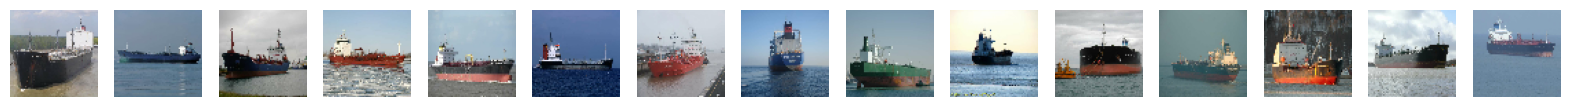

In [3]:
input_dir = str(real_dir + '/' + generating_class)

dataset = keras.utils.image_dataset_from_directory(
    input_dir, label_mode=None, image_size=(64, 64), batch_size=32
)
dataset = dataset.map(lambda x: x / 255.0)

for x in dataset:
    plt.figure(figsize=(20,15))

    for i in range (15):
        plt.subplot(1, 15, i + 1)
        plt.axis("off")
        plt.imshow((x.numpy() * 255).astype("int32")[i])
    break

In [4]:
discriminator = keras.Sequential(
    [
        keras.Input(shape=(64, 64, 3)),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)
discriminator.summary()

Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 64)     │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 128)      │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         8,193 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 404,801 (1.54 MB)

 Trainable params: 404,801 (1.54 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
latent_dim = 128

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(8 * 8 * 128),
        layers.Reshape((8, 8, 128)),
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
    ],
    name="generator",
)
generator.summary()

Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 8192)           │     1,056,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 16, 16, 128)    │       262,272 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 32, 32, 256)    │       524,544 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 64, 64, 512)    │     2,097,664 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 64, 64, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 3)      │        38,403 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,979,651 (15.18 MB)

 Trainable params: 3,979,651 (15.18 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim, d_steps):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_steps = d_steps
        self.seed_generator = keras.random.SeedGenerator(1337)
        

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = ops.shape(real_images)[0]
        total_d_loss = 0.0

        for _ in range(self.d_steps):
            random_latent_vectors = keras.random.normal(
                shape=(batch_size, self.latent_dim), seed=self.seed_generator
            )
    
            # Decode them to fake images
            generated_images = self.generator(random_latent_vectors)
    
            # Combine them with real images
            combined_images = ops.concatenate([generated_images, real_images], axis=0)
    
            # Assemble labels discriminating real from fake images
            labels = ops.concatenate(
                [ops.ones((batch_size, 1)), ops.zeros((batch_size, 1))], axis=0
            )
            # Add random noise to the labels - important trick!
            labels += 0.05 * tf.random.uniform(tf.shape(labels))
    
            # Train the discriminator
            with tf.GradientTape() as tape:
                predictions = self.discriminator(combined_images)
                d_loss = self.loss_fn(labels, predictions)
            grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
            self.d_optimizer.apply_gradients(
                zip(grads, self.discriminator.trainable_weights)
            )
            total_d_loss += d_loss

        avg_d_loss = total_d_loss/self.d_steps
        
        # Update metrics
        self.d_loss_metric.update_state(avg_d_loss)

        # Sample random points in the latent space
        random_latent_vectors = keras.random.normal(
            shape=(batch_size, self.latent_dim), seed=self.seed_generator
        )

        # Assemble labels that say "all real images"
        misleading_labels = ops.zeros((batch_size, 1))
        
        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.g_loss_metric.update_state(g_loss)
            
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

In [7]:
# Diretório onde os modelos serão salvos
checkpoint_dir = str("DCGAN-MODELS/" + generating_class)
os.makedirs(checkpoint_dir, exist_ok=True)

# Caminho do modelo salvo
checkpoint_path = os.path.join(checkpoint_dir, "dcgan_checkpoint.keras")
best_path = os.path.join(checkpoint_dir, "best_dcgan_checkpoint.keras")

# Verifica se há um modelo salvo para continuar o treinamento
if os.path.exists(checkpoint_path):
    print("Carregando modelo salvo para continuar o treinamento...")
    generator = keras.models.load_model(checkpoint_path)
    discriminator = keras.models.load_model(checkpoint_path.replace("dcgan_checkpoint", "dcgan_discriminator"))
else:
    print("Nenhum modelo salvo encontrado. Treinando do zero...")

class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=15, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim
        self.seed_generator = keras.random.SeedGenerator(42)
        self.best_fid = 999

    def on_epoch_end(self, epoch, logs=None):      
        calc_dir = str('DCGAN-RESULTS' + "/" + generating_class)
        os.makedirs(calc_dir, exist_ok=True)
        calc_filename = str(generating_class + "%d.png")
        calc_path = os.path.join(calc_dir, calc_filename)

        random_latent_vectors = keras.random.normal(
            shape=(self.num_img, self.latent_dim), seed=self.seed_generator
        )
        generated_images = gan.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        
        for i in range(self.num_img):
            img = keras.utils.array_to_img(generated_images[i])
            img.save(calc_path % (i))

        real_class_dir = os.path.join(real_dir, generating_class)
        generated_class_dir = os.path.join('DCGAN-RESULTS', generating_class)
        
        real_files = [os.path.join(real_class_dir, f) for f in os.listdir(real_class_dir) if f.endswith(("png", "jpg", "jpeg"))]
        gen_files = [os.path.join(generated_class_dir, f) for f in os.listdir(generated_class_dir) if f.endswith(("png", "jpg", "jpeg"))]
        
        fid = FrechetInceptionDistance()
        
        for real_file, gen_file in zip(real_files, gen_files):
            real_batch = load_image(real_file)
            gen_batch = load_image(gen_file)
            fid.update(real_batch, real=True)
            fid.update(gen_batch, real=False)

        fid_score = fid.compute()
        print(f'   - FID: {fid_score.item()} .')

        save_fid[epoch] = fid_score.item()
        
        if fid_score.item() < self.best_fid:
            self.best_fid = fid_score.item()
            print(f"Melhor FID encontardo: {self.best_fid}, salvando gerador...")
            generator.save(best_path)
            discriminator.save(best_path.replace("best_dcgan_checkpoint", "best_dcgan_discriminator"))

        if (epoch + 1) % 100 == 0:
            plt.figure(figsize=(20, 15))
            for i in range (20):
                plt.subplot(1, 20, i + 1)
                plt.axis("off")
                amostra = keras.utils.array_to_img(generated_images[i])
                plt.imshow(amostra)
            plt.show()
            generator.save(checkpoint_path)
            discriminator.save(checkpoint_path.replace("dcgan_checkpoint", "dcgan_discriminator"))
            print(f"Modelo salvo após {epoch + 1} épocas.")

Nenhum modelo salvo encontrado. Treinando do zero...


In [8]:
### AUMENTO DE IMAGENS ###



weights_path = "RealESRGAN_x4plus.pth"

# Função para baixar os pesos se não existirem
def download_weights():
    if not os.path.exists(weights_path):
        print("Pesos do modelo não encontrados. Fazendo download...")
        url = "https://github.com/xinntao/Real-ESRGAN/releases/download/v0.1.0/RealESRGAN_x4plus.pth"
        response = requests.get(url, stream=True)
        with open(weights_path, "wb") as f:
            for chunk in response.iter_content(chunk_size=8192):
                if chunk:
                    f.write(chunk)
        print("Download concluído!")

# Baixar os pesos, se necessário
download_weights()

def process_images(input_dir, output_dir):
    # Certifique-se de que o diretório de saída existe
    os.makedirs(output_dir, exist_ok=True)

    # Inicialize o modelo Real-ESRGAN
    model = RRDBNet(
        num_in_ch=3, num_out_ch=3, num_feat=64, num_block=23, num_grow_ch=32, scale=4
    )
    upscaler = RealESRGANer(
        scale=4,  # Fator de escala
        model_path=weights_path,  # Caminho dos pesos do modelo
        model=model,  # Modelo definido acima
        tile=0,  # Defina um tamanho de tile se tiver limitações de memória
        tile_pad=10,  # Padding ao redor dos tiles
        pre_pad=0,  # Preenchimento adicional antes do processamento
        half=True,  # Utilize FP16 para economizar memória em GPUs compatíveis
    )

    # Iterar sobre todas as imagens no diretório de entrada
    for filename in tqdm(os.listdir(input_dir),desc="Aumentando imagens"):
        if filename.lower().endswith((".png", ".jpg", ".jpeg", ".bmp", ".tiff")):
            input_path = os.path.join(input_dir, filename)
            output_path = os.path.join(output_dir, filename)

            try:
                # Abra a imagem de entrada
                with Image.open(input_path) as img:
                    # Converta a imagem para array NumPy
                    input_image = np.array(img)

                    # Aplique a super-resolução
                    sr_image, _ = upscaler.enhance(input_image, outscale=4)

                    # Salve a imagem processada
                    Image.fromarray(sr_image).save(output_path)
                    #print(f"Processado: {filename} -> {output_path}")
            except Exception as e:
                print(f"Erro ao processar {filename}: {e}")

In [9]:
### CÁLCULO DE MÉTRICAS ###



# Configurações globais
image_size = 64  # Dimensão para redimensionar imagens
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
])

# Função para carregar e pré-processar uma imagem
def load_image(image_path):
    with Image.open(image_path) as img:
        img = img.convert("RGB")
        tensor = transform(img) * 255  # Escalar de [0, 1] para [0, 255]
        return tensor.to(torch.uint8).unsqueeze(0)  # Adiciona dimensão de batch (1, C, H, W)

# Função para calcular SSIM
def calculate_ssim(img1, img2):
    img1 = np.array(img1)
    img2 = np.array(img2)
    return ssim(img1, img2, channel_axis=-1)

# Função principal para calcular métricas para uma classe específica
def calculate_metrics(real_dir, generated_dir, target_class, num_samples=100, batch_size=10):
    real_class_dir = os.path.join(real_dir, target_class)
    generated_class_dir = os.path.join(generated_dir, target_class)

    # Listar imagens nas pastas
    real_files = [os.path.join(real_class_dir, f) for f in os.listdir(real_class_dir) if f.endswith(("png", "jpg", "jpeg"))]
    gen_files = [os.path.join(generated_class_dir, f) for f in os.listdir(generated_class_dir) if f.endswith(("png", "jpg", "jpeg"))]

    if len(real_files) < num_samples or len(gen_files) < num_samples:
        raise ValueError(f"Imagens insuficientes para a classe '{target_class}'. É necessário pelo menos {num_samples} imagens por classe.")

    sampled_real = np.random.choice(real_files, num_samples, replace=False)
    sampled_gen = np.random.choice(gen_files, num_samples, replace=False)

    ssim_scores = []
    fid = FrechetInceptionDistance()
    inception_score_real = InceptionScore()
    inception_score_gen = InceptionScore()

    # Usar tqdm para mostrar o progresso
    for i in tqdm(range(0, num_samples, batch_size), desc=f"Processando classe '{target_class}'"):
        batch_real_files = sampled_real[i:i + batch_size]
        batch_gen_files = sampled_gen[i:i + batch_size]

        real_batch = []
        gen_batch = []

        for real_file, gen_file in zip(batch_real_files, batch_gen_files):
            with Image.open(real_file) as real_img, Image.open(gen_file) as gen_img:
                real_img = real_img.convert("RGB").resize((image_size, image_size))
                gen_img = gen_img.convert("RGB").resize((image_size, image_size))

                # Calcular SSIM
                ssim_scores.append(calculate_ssim(real_img, gen_img))

                # Preparar imagens para FID e Inception
                real_batch.append(load_image(real_file))
                gen_batch.append(load_image(gen_file))

        # Concatenar batches
        real_batch = torch.cat(real_batch, dim=0)
        gen_batch = torch.cat(gen_batch, dim=0)

        # Atualizar Inception Score e FID por batch
        inception_score_real.update(real_batch)
        inception_score_gen.update(gen_batch)
        fid.update(real_batch, real=True)
        fid.update(gen_batch, real=False)

    # Calcular métricas finais
    is_real, _ = inception_score_real.compute()
    is_gen, _ = inception_score_gen.compute()
    fid_score = fid.compute()

    # Salvar métricas
    metrics = {
        "SSIM (média)": np.mean(ssim_scores),
        "Inception Score (Real)": is_real.item(),
        "Inception Score (Gerado)": is_gen.item(),
        "FID": fid_score.item()
    }

    return metrics

# Função para exibir as métricas
def print_metrics(metrics, target_class):
    print(f"\nMétricas para a classe '{target_class}':")
    for metric, value in metrics.items():
        print(f"  {metric}: {value:.4f}")

# Função para plotar resumo das métricas para a classe
def plot_metrics_for_class(metrics, target_class):
    labels = ["SSIM (média)", "FID", "Inception Score (Real)", "Inception Score (Gerado)"]
    values = [metrics["SSIM (média)"], metrics["FID"], metrics["Inception Score (Real)"], metrics["Inception Score (Gerado)"]]

    plt.figure(figsize=(8, 6))
    bars = plt.bar(labels, values, color=['blue', 'orange', 'green', 'red'])
    plt.title(f"Métricas para a classe '{target_class}'")
    plt.ylabel("Valores")
    plt.tight_layout()

    # Adicionar os valores nas barras
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, f"{height:.2f}", ha='center', va='bottom')

    # Salvar o gráfico
    plt.savefig(f"DCGAN-RESULTS/DCGAN-METRICS-{target_class}.png")
    plt.show()

Epoch 1/1500


I0000 00:00:1745456138.156114     229 service.cc:145] XLA service 0x12f912f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745456138.156159     229 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2025-04-24 00:55:38.210127: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
W0000 00:00:1745456138.274859     229 random_ops.cc:59] Warning: Using tf.random.uniform with XLA compilation will ignore seeds; consider using tf.random.stateless_uniform instead if reproducible behavior is desired. random_uniform/RandomUniform
2025-04-24 00:55:38.514923: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8906
I0000 00:00:1745456146.759323     229 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - d_loss: -0.4418 - g_loss: 106.5439

2025-04-24 00:56:02.120029: W tensorflow/core/kernels/gpu_utils.cc:68] Failed to allocate memory for convolution redzone checking; skipping this check. This is benign and only means that we won't check cudnn for out-of-bounds reads and writes. This message will only be printed once.


   - FID: 328.9331359863281 .
Melhor FID encontardo: 328.9331359863281, salvando gerador...
169/169 ━━━━━━━━━━━━━━━━━━━━ 78s 403ms/step - d_loss: -0.4428 - g_loss: 107.7683
Epoch 2/1500
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 2.8461 - g_loss: 30.4276   - FID: 371.7613830566406 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 52s 306ms/step - d_loss: 2.8457 - g_loss: 30.4955
Epoch 3/1500
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 1.8729 - g_loss: 47.5784   - FID: 288.0048828125 .
Melhor FID encontardo: 288.0048828125, salvando gerador...
169/169 ━━━━━━━━━━━━━━━━━━━━ 52s 306ms/step - d_loss: 1.8711 - g_loss: 47.5860
Epoch 4/1500
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 1.2097 - g_loss: 55.1339   - FID: 320.0188903808594 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 52s 310ms/step - d_loss: 1.2062 - g_loss: 55.0928
Epoch 5/1500
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.6040 - g_loss: 16.4431   - FID: 273.89111328125 .
Melhor FID encontardo: 273.89111328125, salvando gerador...


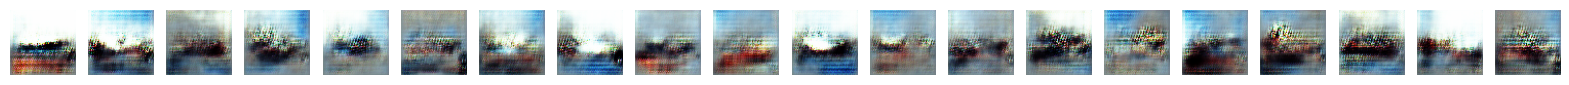

Modelo salvo após 100 épocas.
169/169 ━━━━━━━━━━━━━━━━━━━━ 50s 295ms/step - d_loss: 0.4723 - g_loss: 1.6339
Epoch 101/1500
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.4929 - g_loss: 1.8903   - FID: 217.33023071289062 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 50s 297ms/step - d_loss: 0.4929 - g_loss: 1.8894
Epoch 102/1500
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.4955 - g_loss: 1.7534   - FID: 248.64268493652344 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 50s 296ms/step - d_loss: 0.4956 - g_loss: 1.7536
Epoch 103/1500
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.5508 - g_loss: 1.4932   - FID: 219.9252166748047 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 50s 298ms/step - d_loss: 0.5506 - g_loss: 1.4934
Epoch 104/1500
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.5577 - g_loss: 1.5200   - FID: 224.1273651123047 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 50s 295ms/step - d_loss: 0.5575 - g_loss: 1.5198
Epoch 105/1500
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.4981 - g_loss: 1.5204   - FID

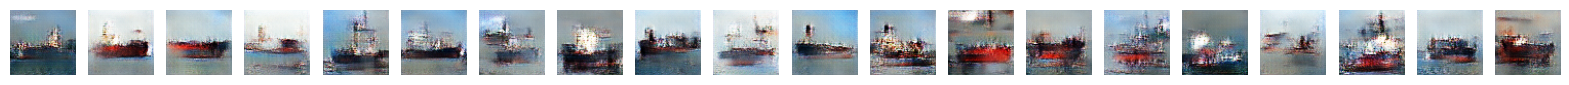

Modelo salvo após 200 épocas.
169/169 ━━━━━━━━━━━━━━━━━━━━ 51s 300ms/step - d_loss: 0.3979 - g_loss: 2.2336
Epoch 201/1500
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.3801 - g_loss: 2.1390   - FID: 98.08626556396484 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 49s 291ms/step - d_loss: 0.3801 - g_loss: 2.1386
Epoch 202/1500
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.3707 - g_loss: 2.1979   - FID: 94.43326568603516 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 50s 299ms/step - d_loss: 0.3707 - g_loss: 2.1978
Epoch 203/1500
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.3599 - g_loss: 2.3226   - FID: 116.01287078857422 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 50s 298ms/step - d_loss: 0.3598 - g_loss: 2.3231
Epoch 204/1500
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.3863 - g_loss: 2.2900   - FID: 87.52851104736328 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 50s 296ms/step - d_loss: 0.3862 - g_loss: 2.2901
Epoch 205/1500
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.3692 - g_loss: 2.4292   - FID:

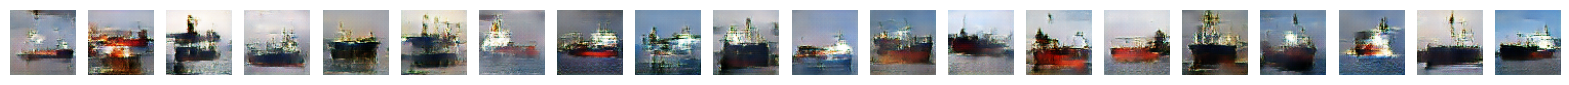

Modelo salvo após 300 épocas.
169/169 ━━━━━━━━━━━━━━━━━━━━ 51s 300ms/step - d_loss: 0.3965 - g_loss: 2.1252
Epoch 301/1500
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.3540 - g_loss: 2.3317   - FID: 51.0816764831543 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 50s 296ms/step - d_loss: 0.3540 - g_loss: 2.3314
Epoch 302/1500
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.3711 - g_loss: 2.2318   - FID: 49.394500732421875 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 50s 293ms/step - d_loss: 0.3711 - g_loss: 2.2318
Epoch 303/1500
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.3979 - g_loss: 2.1958   - FID: 46.365379333496094 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 50s 297ms/step - d_loss: 0.3978 - g_loss: 2.1958
Epoch 304/1500
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.3921 - g_loss: 2.2056   - FID: 53.14656066894531 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 50s 298ms/step - d_loss: 0.3920 - g_loss: 2.2059
Epoch 305/1500
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.3603 - g_loss: 2.3436   - FID:

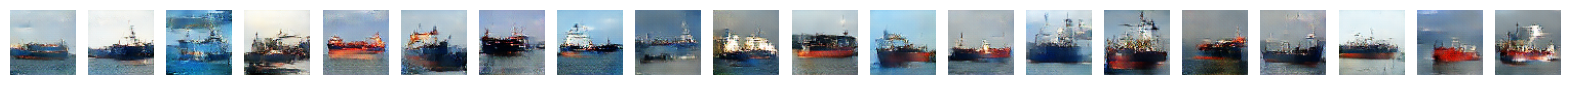

Modelo salvo após 400 épocas.
169/169 ━━━━━━━━━━━━━━━━━━━━ 51s 300ms/step - d_loss: 0.3468 - g_loss: 2.2757
Epoch 401/1500
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.3778 - g_loss: 2.3300   - FID: 53.25460433959961 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 51s 300ms/step - d_loss: 0.3774 - g_loss: 2.3305
Epoch 402/1500
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.3661 - g_loss: 2.4624   - FID: 45.34646987915039 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 50s 298ms/step - d_loss: 0.3659 - g_loss: 2.4623
Epoch 403/1500
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.3519 - g_loss: 2.2382   - FID: 48.62236404418945 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 51s 300ms/step - d_loss: 0.3520 - g_loss: 2.2382
Epoch 404/1500
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.3902 - g_loss: 2.2905   - FID: 48.85691452026367 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 51s 299ms/step - d_loss: 0.3900 - g_loss: 2.2913
Epoch 405/1500
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.3218 - g_loss: 2.5334   - FID: 

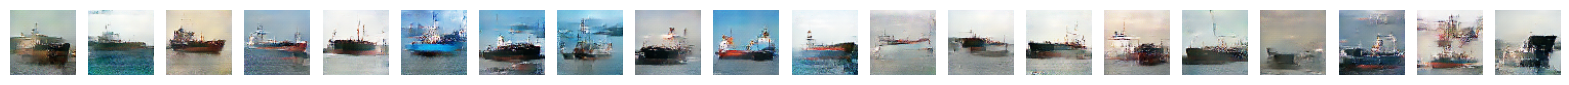

Modelo salvo após 500 épocas.
169/169 ━━━━━━━━━━━━━━━━━━━━ 51s 302ms/step - d_loss: 0.3186 - g_loss: 2.5889
Epoch 501/1500
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.3103 - g_loss: 2.4927   - FID: 43.2580451965332 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 51s 301ms/step - d_loss: 0.3103 - g_loss: 2.4926
Epoch 502/1500
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.3031 - g_loss: 2.5782   - FID: 44.37667465209961 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 51s 299ms/step - d_loss: 0.3031 - g_loss: 2.5792
Epoch 503/1500
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.3210 - g_loss: 2.7324   - FID: 47.22696304321289 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 50s 296ms/step - d_loss: 0.3209 - g_loss: 2.7323
Epoch 504/1500
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.3142 - g_loss: 2.4768   - FID: 41.55368423461914 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 53s 313ms/step - d_loss: 0.3142 - g_loss: 2.4768
Epoch 505/1500
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.3269 - g_loss: 2.4083   - FID: 4

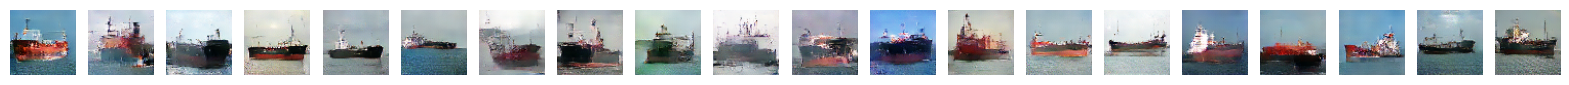

Modelo salvo após 600 épocas.
169/169 ━━━━━━━━━━━━━━━━━━━━ 51s 301ms/step - d_loss: 0.2897 - g_loss: 2.7771
Epoch 601/1500
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.2612 - g_loss: 2.8612   - FID: 42.56934356689453 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 51s 301ms/step - d_loss: 0.2613 - g_loss: 2.8613
Epoch 602/1500
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.2551 - g_loss: 3.0286   - FID: 40.673099517822266 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 51s 300ms/step - d_loss: 0.2551 - g_loss: 3.0288
Epoch 603/1500
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.2528 - g_loss: 3.0642   - FID: 40.90147018432617 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 51s 300ms/step - d_loss: 0.2528 - g_loss: 3.0643
Epoch 604/1500
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.2778 - g_loss: 2.9135   - FID: 39.18688201904297 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 50s 297ms/step - d_loss: 0.2777 - g_loss: 2.9141
Epoch 605/1500
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.2627 - g_loss: 2.9516   - FID:

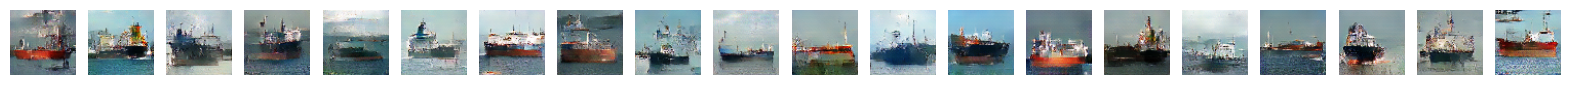

Modelo salvo após 700 épocas.
169/169 ━━━━━━━━━━━━━━━━━━━━ 51s 299ms/step - d_loss: 0.2052 - g_loss: 3.8512
Epoch 701/1500
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.1832 - g_loss: 4.0318   - FID: 47.063926696777344 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 51s 299ms/step - d_loss: 0.1833 - g_loss: 4.0307
Epoch 702/1500
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.1958 - g_loss: 3.6630   - FID: 39.04182052612305 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 50s 298ms/step - d_loss: 0.1958 - g_loss: 3.6633
Epoch 703/1500
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.2061 - g_loss: 3.5977   - FID: 38.05669021606445 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 50s 298ms/step - d_loss: 0.2061 - g_loss: 3.5966
Epoch 704/1500
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.2087 - g_loss: 3.5307   - FID: 44.50884246826172 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 50s 297ms/step - d_loss: 0.2087 - g_loss: 3.5312
Epoch 705/1500
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.2130 - g_loss: 3.5889   - FID:

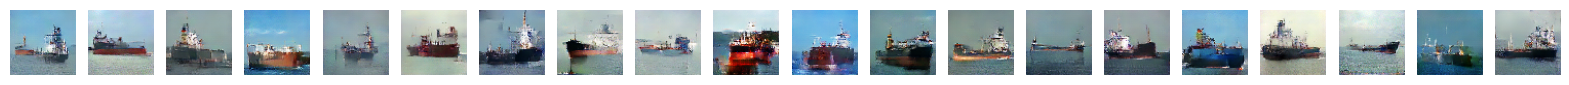

Modelo salvo após 800 épocas.
169/169 ━━━━━━━━━━━━━━━━━━━━ 51s 299ms/step - d_loss: 0.1549 - g_loss: 4.5956
Epoch 801/1500
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.1642 - g_loss: 4.1761   - FID: 41.01707077026367 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 50s 297ms/step - d_loss: 0.1642 - g_loss: 4.1768
Epoch 802/1500
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.1527 - g_loss: 4.8048   - FID: 41.075958251953125 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 50s 298ms/step - d_loss: 0.1526 - g_loss: 4.8041
Epoch 803/1500
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.1558 - g_loss: 4.5130   - FID: 41.7790641784668 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 50s 298ms/step - d_loss: 0.1558 - g_loss: 4.5129
Epoch 804/1500
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.1639 - g_loss: 4.4324   - FID: 39.43666076660156 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 50s 296ms/step - d_loss: 0.1638 - g_loss: 4.4326
Epoch 805/1500
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.1579 - g_loss: 4.3740   - FID: 

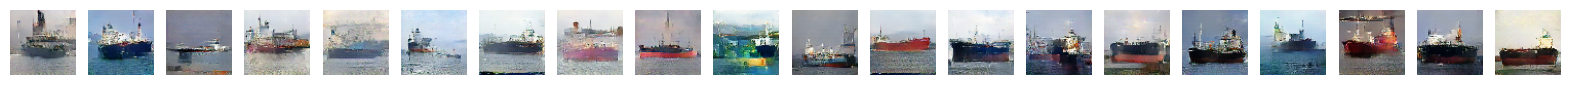

Modelo salvo após 900 épocas.
169/169 ━━━━━━━━━━━━━━━━━━━━ 52s 308ms/step - d_loss: 0.1249 - g_loss: 5.2270
Epoch 901/1500
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.1107 - g_loss: 5.5058   - FID: 40.437625885009766 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 52s 305ms/step - d_loss: 0.1107 - g_loss: 5.5052
Epoch 902/1500
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.1129 - g_loss: 5.5266   - FID: 39.77549743652344 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 51s 302ms/step - d_loss: 0.1129 - g_loss: 5.5265
Epoch 903/1500
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.1297 - g_loss: 5.4168   - FID: 41.96682357788086 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 51s 301ms/step - d_loss: 0.1297 - g_loss: 5.4166
Epoch 904/1500
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.1277 - g_loss: 5.3396   - FID: 41.21430969238281 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 51s 301ms/step - d_loss: 0.1276 - g_loss: 5.3395
Epoch 905/1500
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.1098 - g_loss: 5.4050   - FID:

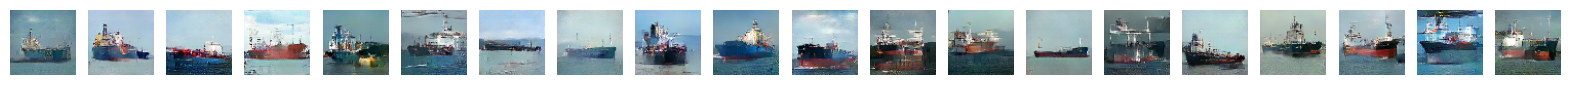

Modelo salvo após 1000 épocas.
169/169 ━━━━━━━━━━━━━━━━━━━━ 53s 315ms/step - d_loss: 0.0787 - g_loss: 6.5956
Epoch 1001/1500
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.0843 - g_loss: 6.5787   - FID: 41.605159759521484 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 53s 312ms/step - d_loss: 0.0842 - g_loss: 6.5792
Epoch 1002/1500
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.0953 - g_loss: 6.5026   - FID: 40.173492431640625 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 53s 314ms/step - d_loss: 0.0953 - g_loss: 6.5016
Epoch 1003/1500
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.0933 - g_loss: 6.3729   - FID: 39.560325622558594 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 52s 307ms/step - d_loss: 0.0932 - g_loss: 6.3742
Epoch 1004/1500
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.1066 - g_loss: 6.4982   - FID: 40.23929977416992 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 53s 314ms/step - d_loss: 0.1065 - g_loss: 6.4984
Epoch 1005/1500
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.0772 - g_loss: 6.5271 

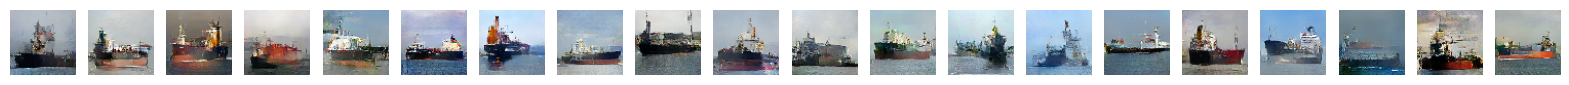

Modelo salvo após 1100 épocas.
169/169 ━━━━━━━━━━━━━━━━━━━━ 52s 309ms/step - d_loss: 0.0506 - g_loss: 7.9166
Epoch 1101/1500
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.0869 - g_loss: 7.3209   - FID: 47.73334503173828 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 52s 308ms/step - d_loss: 0.0868 - g_loss: 7.3223
Epoch 1102/1500
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.0624 - g_loss: 7.7436   - FID: 41.14000701904297 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 52s 306ms/step - d_loss: 0.0623 - g_loss: 7.7443
Epoch 1103/1500
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.0657 - g_loss: 8.0355   - FID: 43.820438385009766 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 52s 307ms/step - d_loss: 0.0657 - g_loss: 8.0344
Epoch 1104/1500
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.0632 - g_loss: 7.9500   - FID: 40.57966995239258 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 51s 303ms/step - d_loss: 0.0632 - g_loss: 7.9501
Epoch 1105/1500
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.0788 - g_loss: 7.4733   

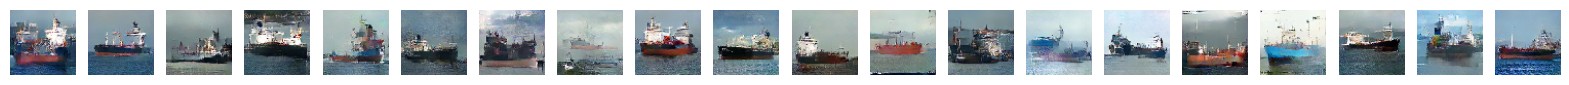

Modelo salvo após 1200 épocas.
169/169 ━━━━━━━━━━━━━━━━━━━━ 52s 305ms/step - d_loss: 0.0381 - g_loss: 9.4050
Epoch 1201/1500
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.0559 - g_loss: 8.7072   - FID: 41.06822204589844 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 51s 301ms/step - d_loss: 0.0559 - g_loss: 8.7080
Epoch 1202/1500
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.0358 - g_loss: 9.2992   - FID: 41.822200775146484 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 52s 305ms/step - d_loss: 0.0359 - g_loss: 9.2976
Epoch 1203/1500
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.0500 - g_loss: 9.2590   - FID: 43.35797119140625 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 51s 304ms/step - d_loss: 0.0499 - g_loss: 9.2591
Epoch 1204/1500
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.0407 - g_loss: 9.5179   - FID: 39.53651428222656 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 54s 319ms/step - d_loss: 0.0407 - g_loss: 9.5181
Epoch 1205/1500
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.0373 - g_loss: 9.4365   

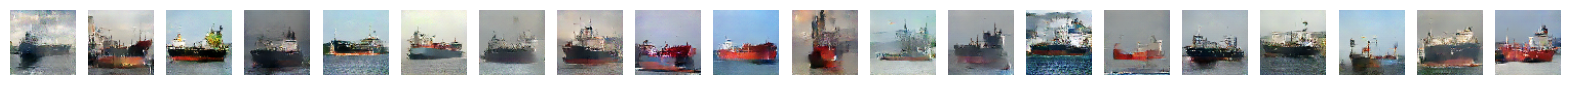

Modelo salvo após 1300 épocas.
169/169 ━━━━━━━━━━━━━━━━━━━━ 53s 311ms/step - d_loss: 0.0166 - g_loss: 10.5005
Epoch 1301/1500
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.0389 - g_loss: 10.1091   - FID: 42.86661911010742 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 52s 308ms/step - d_loss: 0.0390 - g_loss: 10.1095
Epoch 1302/1500
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.0441 - g_loss: 10.5912   - FID: 42.449867248535156 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 52s 307ms/step - d_loss: 0.0441 - g_loss: 10.5908
Epoch 1303/1500
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.0305 - g_loss: 10.6119   - FID: 39.65766906738281 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 54s 319ms/step - d_loss: 0.0305 - g_loss: 10.6141
Epoch 1304/1500
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.0419 - g_loss: 11.4286   - FID: 40.00584411621094 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 53s 314ms/step - d_loss: 0.0419 - g_loss: 11.4270
Epoch 1305/1500
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.0309 - g_loss: 

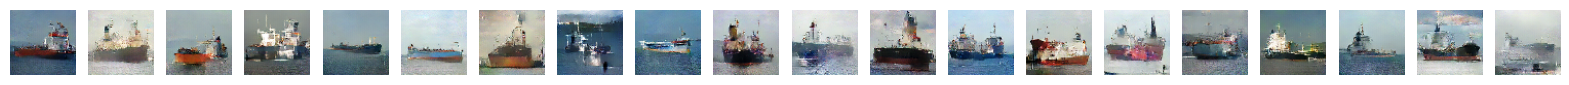

Modelo salvo após 1400 épocas.
169/169 ━━━━━━━━━━━━━━━━━━━━ 54s 319ms/step - d_loss: 0.0149 - g_loss: 12.3276
Epoch 1401/1500
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.0252 - g_loss: 12.4533   - FID: 43.37338638305664 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 55s 324ms/step - d_loss: 0.0250 - g_loss: 12.4541
Epoch 1402/1500
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: -0.0014 - g_loss: 12.6139   - FID: 41.07241439819336 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 53s 315ms/step - d_loss: -0.0013 - g_loss: 12.6122
Epoch 1403/1500
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.0127 - g_loss: 12.6883   - FID: 42.618621826171875 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 53s 314ms/step - d_loss: 0.0126 - g_loss: 12.6885
Epoch 1404/1500
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.0266 - g_loss: 12.1273   - FID: 39.58049392700195 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 53s 311ms/step - d_loss: 0.0266 - g_loss: 12.1283
Epoch 1405/1500
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.0050 - g_loss

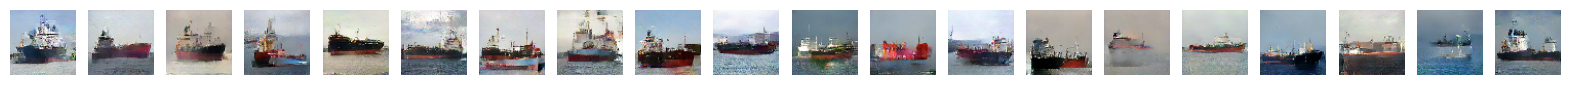

Modelo salvo após 1500 épocas.
169/169 ━━━━━━━━━━━━━━━━━━━━ 54s 319ms/step - d_loss: 0.0036 - g_loss: 14.0556


In [10]:
### EXECUÇÃO ###



epochs = 1500
d_steps = 3
latent_dim = 128

save_fid = np.zeros(epochs)

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim, d_steps=d_steps)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

history = gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=540, latent_dim=latent_dim)]
)

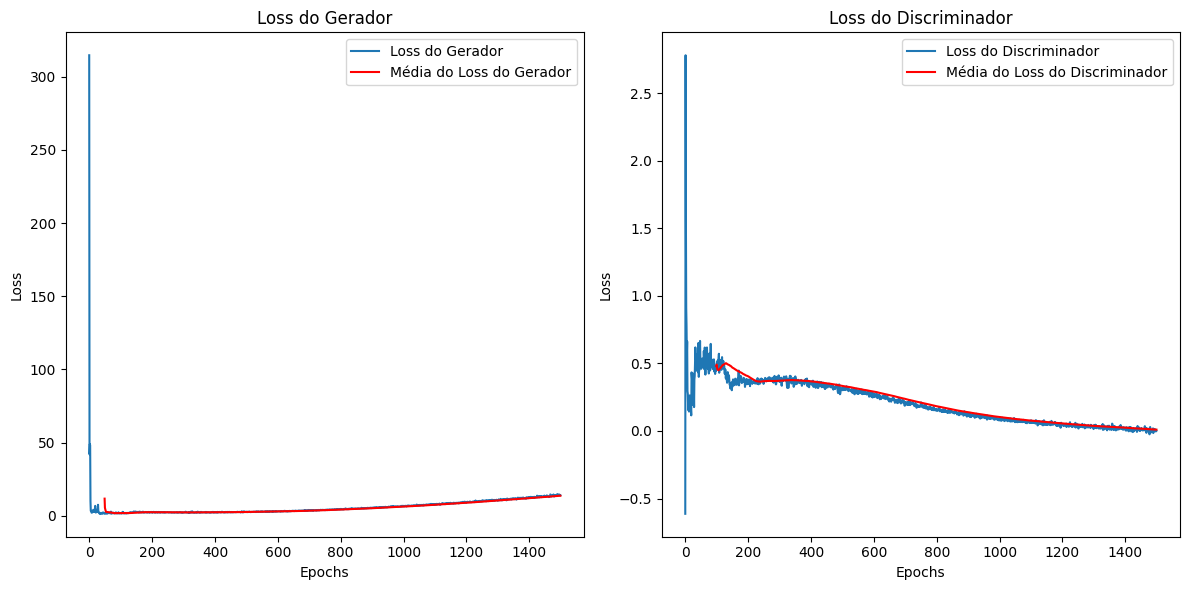

In [11]:
generator_loss = history.history['g_loss']
generator_loss_series = pd.Series(generator_loss)
generator_loss_rolling = generator_loss_series.rolling(window=50).mean()

discriminator_loss = history.history['d_loss']
discriminator_loss_series = pd.Series(discriminator_loss)
discriminator_loss_rolling = discriminator_loss_series.rolling(window=100).mean()

plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.plot(generator_loss, label='Loss do Gerador')
plt.plot(generator_loss_rolling, color='r', linestyle='-', label = 'Média do Loss do Gerador')
plt.title('Loss do Gerador')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(discriminator_loss, label='Loss do Discriminador')
plt.plot(discriminator_loss_rolling, color='r', linestyle='-', label = 'Média do Loss do Discriminador')
plt.title('Loss do Discriminador')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Menor FID:           36.46908950805664
Época da menor perda:  776


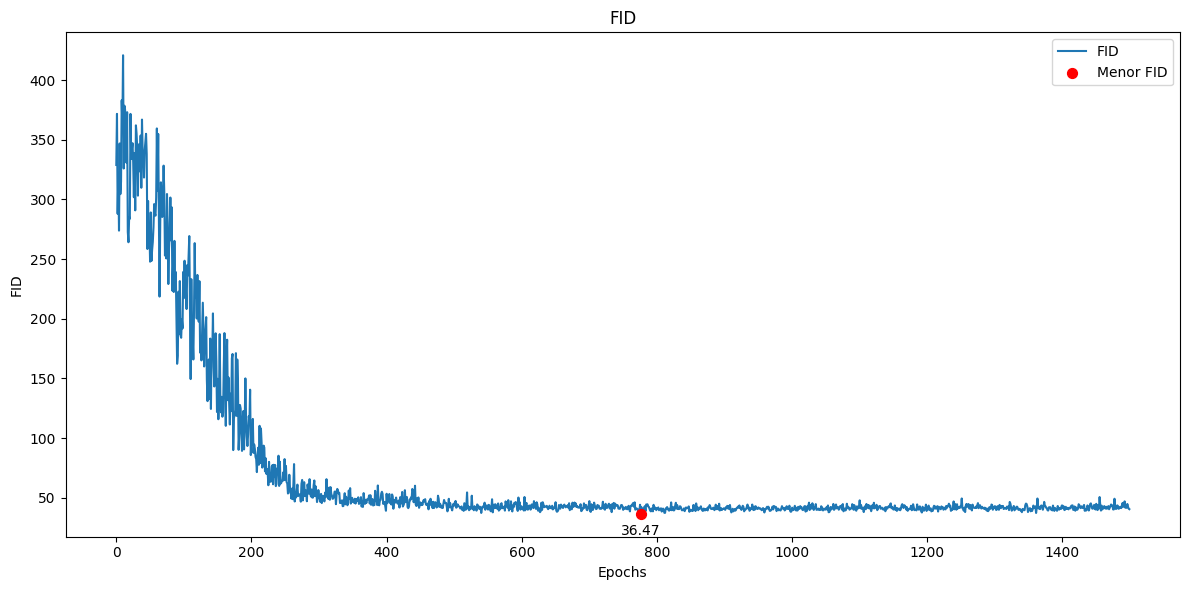

In [12]:
menor_fid = 999
for i in range(epochs):
    if save_fid[i]<menor_fid:
        menor_fid = save_fid[i]
        epoch_m = i
        
print('Menor FID:          ',menor_fid)
print('Época da menor perda: ',epoch_m)

plt.figure(figsize=(12,6))
plt.plot(save_fid, label='FID')
plt.scatter(epoch_m, menor_fid, color='r', zorder=5, label = 'Menor FID', s=50)
plt.text(epoch_m, menor_fid-20, f"{menor_fid:.2f}", ha='center', va='bottom')
plt.title('FID')
plt.xlabel('Epochs')
plt.ylabel('FID')
plt.legend()

plt.tight_layout()
plt.show()

In [13]:
generator = keras.models.load_model(best_path)
discriminator = keras.models.load_model(best_path.replace("best_dcgan_checkpoint", "best_dcgan_discriminator"))

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim, d_steps=d_steps)

In [14]:
num_img = 5400
output_dir = str(fake_dir + "/" + generating_class + "/")
os.makedirs(output_dir, exist_ok=True)
filename = str(generating_class + "%d.png")
output_path = os.path.join(output_dir, filename)

latent_dim=128
seed_generator = keras.random.SeedGenerator(1337)

for i in tqdm(range(num_img),desc="Gerando imagens"):
    random_latent_vectors = keras.random.normal(
        shape=(1, latent_dim), seed=seed_generator
    )
    generated_images = gan.generator(random_latent_vectors)
    generated_images *= 255
    generated_images.numpy()
    img = keras.utils.array_to_img(generated_images[0])
    img.save(output_path % (i))

Gerando imagens: 100%|██████████████████████████████████████████████████████████████| 5400/5400 [01:00<00:00, 88.62it/s]


/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `InceptionScore` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)  # noqa: B028
Processando classe 'OILPRODUCTSTANKER': 100%|█████████████████████████████████████████| 540/540 [07:46<00:00,  1.16it/s]



Métricas para a classe 'OILPRODUCTSTANKER':
  SSIM (média): 0.2487
  Inception Score (Real): 1.7398
  Inception Score (Gerado): 1.6391
  FID: 26.1343


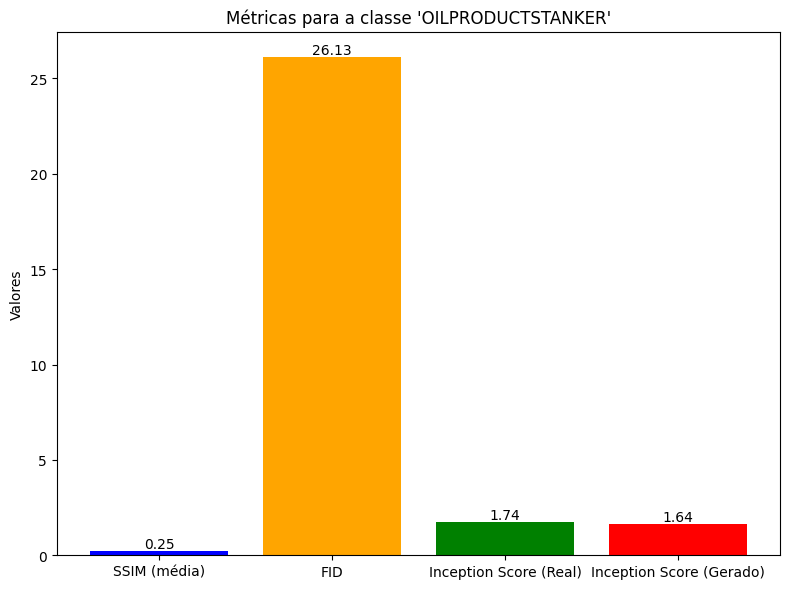

In [15]:
metrics = calculate_metrics(real_dir, fake_dir, generating_class, num_samples=num_img)
print_metrics(metrics, generating_class)
plot_metrics_for_class(metrics, generating_class)

In [16]:
# Caminhos para as imagens de entrada e saída
input_dir = str(fake_dir + '/' + generating_class)   # Substitua pelo diretório das imagens de entrada
output_dir = str(fake_dirx4 + '/' + generating_class)  # Substitua pelo diretório das imagens de saída

# Certifique-se de que o diretório de saída existe
os.makedirs(output_dir, exist_ok=True)

process_images(input_dir, output_dir)
print("Processamento concluído!")

Aumentando imagens: 100%|███████████████████████████████████████████████████████████| 5400/5400 [04:50<00:00, 18.56it/s]

Processamento concluído!


Processando classe 'OILPRODUCTSTANKER': 100%|█████████████████████████████████████████| 540/540 [08:03<00:00,  1.12it/s]



Métricas para a classe 'OILPRODUCTSTANKER':
  SSIM (média): 0.2915
  Inception Score (Real): 1.7409
  Inception Score (Gerado): 1.7037
  FID: 14.7756


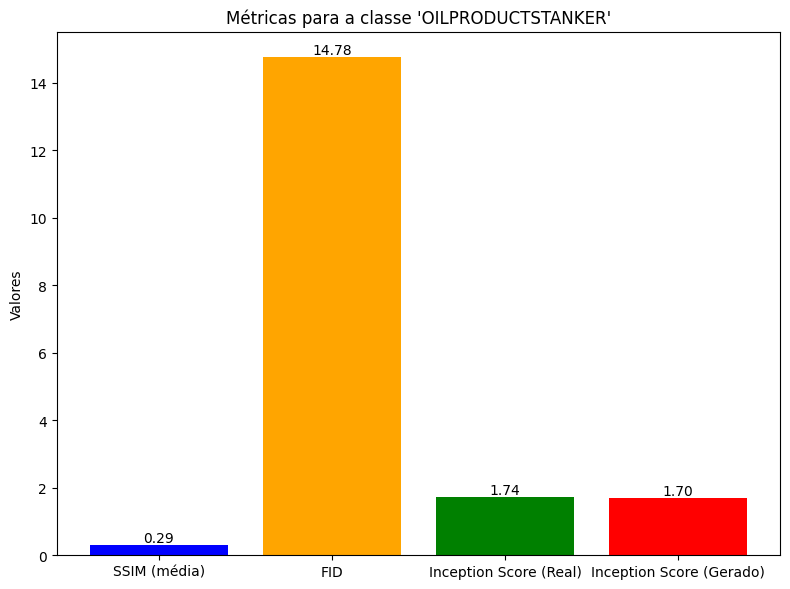

In [17]:
metrics = calculate_metrics(real_dir, fake_dirx4, generating_class, num_samples=num_img)
print_metrics(metrics, generating_class)
plot_metrics_for_class(metrics, generating_class)